In [1]:
import numpy
import scipy.sparse
from matplotlib import pyplot
import os
import pickle
from tqdm.notebook import tqdm
import qubit_matmul
import shadow_reconstruction

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# Load data

In [2]:
base_dirs = {
    "/home/sumner/Desktop/NumConsShadows/ladder_single_condensed_L24_M6_open": (24, 6, -0.5),
    "/home/sumner/Desktop/NumConsShadows/ladder_very_single_condensed_L24_M6_open": (24, 6, -2.0),
    "/home/sumner/Desktop/NumConsShadows/ladder_pair_condensed_L24_M6_open": (24, 6, -0.05),
}

In [3]:
data = {}

for k, (l, m, j) in base_dirs.items():
    gs = None
    all_samples = []
    for bb, _, ff in os.walk(k):
        for f in ff:
            filename = os.path.join(bb,f)
            if f.endswith('.data'):
                samples = shadow_reconstruction.Samples.load_from(filename)
                all_samples.append(samples)
            elif gs is None and f.endswith(".npz"):
                gs = numpy.load(filename)['gs']
    acc = all_samples[0]
    for s in all_samples[1:]:
        acc.add_from(s)
    # acc = acc.subset(100_000)
    print("Samples: {}".format(acc.num_samples()))
    data[k] = (l,j,m,acc,gs)

Samples: 8000000
Samples: 8000000
Samples: 8000000


# Set parameters

In [4]:
n_subsamples = 20_000
n_trials = 1000
dt = 1e-6

In [5]:
single_data = data["/home/sumner/Desktop/NumConsShadows/ladder_pair_condensed_L24_M6_open"]

# Shadow distribution

In [6]:
(l,j,m,acc,gs) = single_data
subacc = acc.subset(min(n_trials * n_subsamples, acc.num_samples()))

recon = shadow_reconstruction.Reconstruction(filtered=False)
estimates = recon.estimate_string_for_each_sample('++--' + 'I'*20, subacc)
estimates.mean(), estimates.max(), estimates.min()

((0.22217245312500003+0.0016301250000000035j),
 (543.3750000000007+0j),
 (-543.3750000000007+0j))

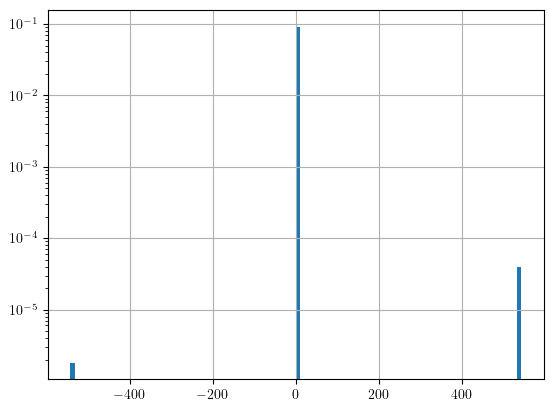

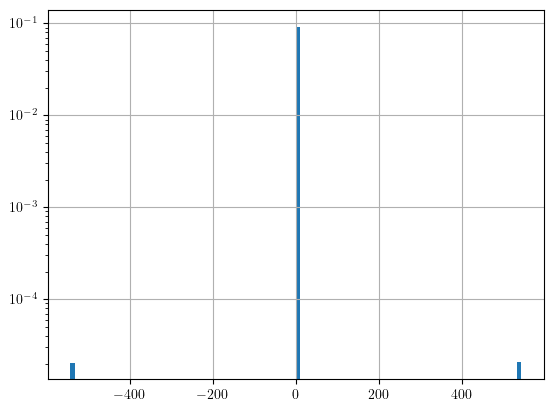

In [7]:
pyplot.hist(estimates.real, bins=100, density=True)
pyplot.grid()
pyplot.yscale('log')
pyplot.show()

pyplot.hist(estimates.imag, bins=100, density=True)
pyplot.grid()
pyplot.yscale('log')
pyplot.show()

# Analyze Shadows - Look at empirical mean for `n_trials` independent runs
In each run, subsample the full data set to `n_subsamples` shadows. Look at the mean of just those.

In [8]:
data_means = []
data_vars = []
for _ in tqdm(range(n_trials)):
    (l,j,m,acc,gs) = single_data
    subacc = acc.subset(n_subsamples)
    
    recon = shadow_reconstruction.Reconstruction(filtered=False)
    estimates = recon.estimate_string_for_each_sample('++--' + 'I'*20, subacc)
    data_means.append(estimates.mean())
    data_vars.append(estimates.var()/len(estimates))
data_means = numpy.array(data_means)
data_vars = numpy.array(data_vars)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
data_means.mean().real, numpy.sqrt(data_means.var()), numpy.sqrt(data_vars.mean())

(0.22014838125000022, 0.11304022641047388, 0.11429570996084687)

Notice that the std of the means is close to the sqrt of the average variance.

# Analyze Shadows - Look at median of means for `n_trials` independent runs
In each run, subsample the full data set to `n_subsamples` shadows. Look at the median of `k` means of just those.

First take `k=4` then take `k=10`

In [10]:
def median_of_means(data, k=4):
    arrs = numpy.split(data, k)
    means = [numpy.mean(arr) for arr in arrs]
    return numpy.median(means)
median_of_means(numpy.arange(100)), numpy.arange(100).mean()

(49.5, 49.5)

In [11]:
data_medians = []
for _ in tqdm(range(n_trials)):
    (l,j,m,acc,gs) = single_data
    subacc = acc.subset(n_subsamples)
    
    recon = shadow_reconstruction.Reconstruction(filtered=False)
    estimates = recon.estimate_string_for_each_sample('++--' + 'I'*20, subacc)
    mofm =  median_of_means(estimates)
    data_medians.append(mofm)
data_medians = numpy.array(data_medians)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
data_medians.mean().real, numpy.sqrt(data_medians.var())

(0.21077516250000022, 0.14169976100027826)

In [13]:
data_more_medians = []
for _ in tqdm(range(n_trials)):
    (l,j,m,acc,gs) = single_data
    subacc = acc.subset(n_subsamples)
    
    recon = shadow_reconstruction.Reconstruction(filtered=False)
    estimates = recon.estimate_string_for_each_sample('++--' + 'I'*20, subacc)
    mofm =  median_of_means(estimates, k=10)
    data_more_medians.append(mofm)
data_more_medians = numpy.array(data_more_medians)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
data_more_medians.mean().real, numpy.sqrt(data_more_medians.var())

(0.17958543750000017, 0.23078197994655023)

# Variance looks as larger, histogram shows why

In [15]:
data_means.real.std(), data_medians.real.std(), data_more_medians.real.std()

(0.08053319336273691, 0.08657174576329657, 0.1215263380710736)

In [19]:
data_means.imag.std(), data_medians.imag.std(), data_more_medians.imag.std()

(0.07932526428403011, 0.11217912061979768, 0.19619294437640983)

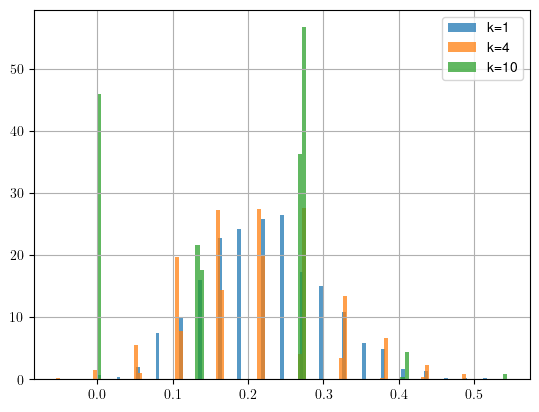

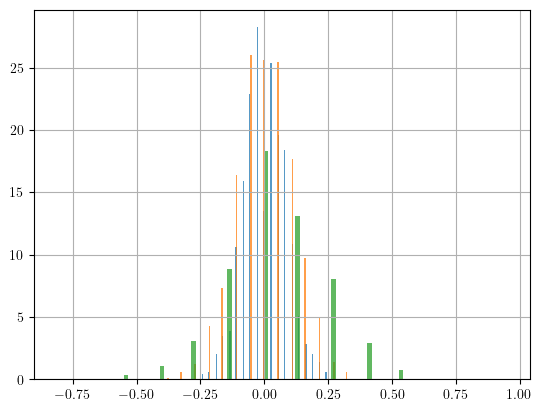

In [16]:
pyplot.hist(data_means.real, alpha=0.75, bins=100, density=True, label='k=1')
pyplot.hist(data_medians.real, alpha=0.75, bins=100, density=True, label='k=4')
pyplot.hist(data_more_medians.real, alpha=0.75, bins=100, density=True, label='k=10')
pyplot.grid()
pyplot.legend()
pyplot.show()

pyplot.hist(data_means.imag, alpha=0.75, bins=100, density=True)
pyplot.hist(data_medians.imag, alpha=0.75, bins=100, density=True)
pyplot.hist(data_more_medians.imag, alpha=0.75, bins=100, density=True)
pyplot.grid()
pyplot.show()